<a href="https://colab.research.google.com/github/dscer/DS6050_Codeathon_3/blob/main/ybt7qf_codeathon_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install keras_nlp -q

# GPT Text Generation Tutorial (Gutenberg dataset)

In [29]:
import os
import math
import time
import keras
import keras_nlp
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

## Settings & hyperparameters

In [ ]:
# Data
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 450

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000  # Limits parameters in model.

# Training
EPOCHS = 6

# Inference
NUM_TOKENS_TO_GENERATE = 80

## Load the data

In [ ]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
)
dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

# Load simplebooks-92 train set and filter out short lines.
raw_train_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

# Load simplebooks-92 validation set and filter out short lines.
raw_val_ds = (
    tf.data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .batch(BATCH_SIZE)
)

282386239/282386239 [==============================] - 8s 0us/step


## Train the tokenizer

In [ ]:
# Train tokenizer vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

## Load tokenizer

In [ ]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

## Tokenize data

In [ ]:
# packer adds a start token
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

## Build the model

In [ ]:
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
# Embedding.
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         1312768   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_decoder (Trans  (None, None, 256)         394749    
 formerDecoder)                                                  
                                                                 
 transformer_decoder_1 (Tra  (None, None, 256)         394749    
 nsformerDecoder)                                                
                                                                 
 dense (Dense)               (None, None, 5000)        128500

## Training

In [ ]:
model.fit(train_ds, validation_data=val_ds, verbose=2, epochs=EPOCHS)

Epoch 1/6


## Inference

In [ ]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

In [ ]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache

### Greedy search


In [ ]:
sampler = keras_nlp.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

### Beam search

In [ ]:
sampler = keras_nlp.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

### Random search

In [ ]:
sampler = keras_nlp.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

### Top-K search

In [ ]:
sampler = keras_nlp.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

### Top-P search


In [ ]:
sampler = keras_nlp.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

### Using callbacks for text generation

In [ ]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k):
        self.sampler = keras_nlp.samplers.TopKSampler(k)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"Top-K search generated text: \n{txt}\n")


text_generation_callback = TopKTextGenerator(k=10)
# Dummy training loop to demonstrate callback.
model.fit(train_ds.take(1), verbose=2, epochs=2, callbacks=[text_generation_callback])

# Text Generation with KerasNLP (Reddit dataset)


## Preprocess Reddit dataset

In [7]:
reddit_ds = tfds.load("reddit_tifu", split="train", as_supervised=True)

In [8]:
for document, title in reddit_ds:
    print(document.numpy())
    print(title.numpy())
    break

b"me and a friend decided to go to the beach last sunday. we loaded up and headed out. we were about half way there when i decided that i was not leaving till i had seafood. \n\nnow i'm not talking about red lobster. no friends i'm talking about a low country boil. i found the restaurant and got directions. i don't know if any of you have heard about the crab shack on tybee island but let me tell you it's worth it. \n\nwe arrived and was seated quickly. we decided to get a seafood sampler for two and split it. the waitress bought it out on separate platters for us. the amount of food was staggering. two types of crab, shrimp, mussels, crawfish, andouille sausage, red potatoes, and corn on the cob. i managed to finish it and some of my friends crawfish and mussels. it was a day to be a fat ass. we finished paid for our food and headed to the beach. \n\nfunny thing about seafood. it runs through me faster than a kenyan \n\nwe arrived and walked around a bit. it was about 45min since we a

In [9]:
train_ds = (
    reddit_ds.map(lambda document, _: document)
    .batch(32)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

## Fine-tune Pre-Trained Models

### Reusable Training Configs

In [63]:
train_ds = train_ds.take(500)
num_epochs = 1

In [40]:
# Linearly decaying learning rate.
learning_rate = keras.optimizers.schedules.PolynomialDecay(
    5e-5,
    decay_steps=train_ds.cardinality() * num_epochs,
    end_learning_rate=0.0,
)

In [41]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Callbacks

In [43]:
class GPUMemoryCallback(keras.callbacks.Callback):
    def __init__(
        self,
        target_batches,
        print_stats=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.target_batches = target_batches
        self.print_stats = print_stats

        self.memory_usage = []
        self.labels = []

    def _compute_memory_usage(self):
        memory_stats = tf.config.experimental.get_memory_info("GPU:0")
        # Convert bytes to GB and store in list.
        peak_usage = round(memory_stats["peak"] / (2**30), 3)
        self.memory_usage.append(peak_usage)

    def on_epoch_begin(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} start")

    def on_train_batch_begin(self, batch, logs=None):
        if batch in self.target_batches:
            self._compute_memory_usage()
            self.labels.append(f"batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} end")

### General Functions

In [35]:
def generate_text(model, input_text, max_length=200):
    start = time.time()

    output = model.generate(input_text, max_length=max_length)
    print("\nOutput:")
    print(output)

    end = time.time()
    print(f"Total Time Elapsed: {end - start:.2f}s")

In [36]:
def plot_memory_use(model_list: list, memory_use: dict):
    plt.bar(
      model_list,
      [max(v) for k, v in memory_use.items()],
      color=["red", "blue", "green", "orange", "cyan"],
    )

    plt.xlabel("Time")
    plt.ylabel("GPU Memory Usage (in GB)")

    plt.title("GPU Memory Usage Comparison")
    plt.legend()
    plt.show()

### GPT2 Models

In [44]:
gpt2_model_list = [
    "gpt2_base_en",
    # "gpt2_medium_en",
    # "gpt2_large_en",
    # "gpt2_extra_large_en",
]

gpt2_memory_use = {}

for model_name in gpt2_model_list:

    print(f"-------- Training {model_name} ---------------")

    preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
        model_name,
        sequence_length=128,
    )
    tmp_lm = keras_nlp.models.GPT2CausalLM.from_preset(
        model_name, preprocessor=preprocessor
    )

    tmp_lm.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    gpu_memory_callback = GPUMemoryCallback(
        target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
        print_stats=True,
    )

    tmp_lm.fit(train_ds,
               epochs=num_epochs,
               callbacks=[gpu_memory_callback])

    gpt2_memory_use[model_name] = gpu_memory_callback.memory_usage

    generate_text(tmp_lm, "I like basketball")

-------- Training gpt2_base_en ---------------
 6/10 [=================>............] - ETA: 4s - loss: 3.6706 - accuracy: 0.2903

10/10 [==============================] - 85s 1s/step - loss: 3.6422 - accuracy: 0.2932

Output:
I like basketball. I'm a huge basketball fan. I love watching them play. I'm not going to go into the details here, but I do have a lot to say about the game, and I'm going to go into a lot of detail here. The first thing I want to talk about is the fact that this is a team that plays a lot of basketball. I think the reason this team has been so successful so far is because of their defense. The team has a lot of guys who can make a big impact in the paint, but they also can make a huge impact on the offensive end, so the offense is really going to be a big part of it. It's going to be an offense of some kind in the playoffs.

I'm also curious to see where the team goes next. They've had a couple of good games, which means that they're going to have a chance to play some of the better teams out there. The Celtics will play
Total Time Elapsed: 20.27s


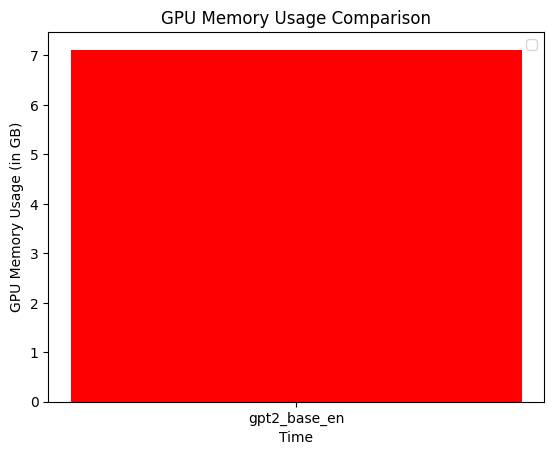

In [45]:
plot_memory_use(gpt2_model_list, gpt2_memory_use)

## OPT Models

In [46]:
opt_model_list = [
    "opt_125m_en",
    # "opt_1.3b_en",
    # "opt_2.7b_en",
    # "opt_6.7b_en"
]

opt_memory_use = {}

for model_name in opt_model_list:

    print(f"-------- Training {model_name} ---------------")

    preprocessor = keras_nlp.models.OPTCausalLMPreprocessor.from_preset(
        model_name,
        sequence_length=128,
    )
    tmp_lm = keras_nlp.models.OPTCausalLM.from_preset(
        model_name, preprocessor=preprocessor
    )

    tmp_lm.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    gpu_memory_callback = GPUMemoryCallback(
        target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
        print_stats=True,
    )

    tmp_lm.fit(train_ds,
               epochs=num_epochs,
               callbacks=[gpu_memory_callback])

    opt_memory_use[model_name] = gpu_memory_callback.memory_usage

    generate_text(tmp_lm, "I like basketball")

-------- Training opt_125m_en ---------------
 6/10 [=================>............] - ETA: 4s - loss: 3.3443 - accuracy: 0.3273

10/10 [==============================] - 66s 1s/step - loss: 3.3266 - accuracy: 0.3286

Output:
I like basketball, I'm not sure I can handle it.
But I'm sure I can handle it when I play basketball.
So this week I'm going to try and make some basketball videos.
I'll post a video when I do.
(I'll post it on the site after a few days.
Total Time Elapsed: 17.33s


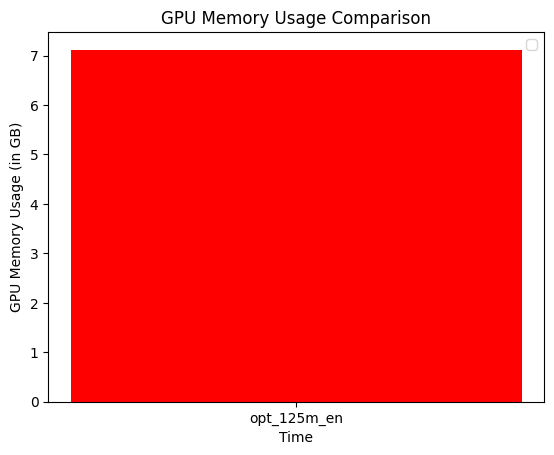

In [47]:
plot_memory_use(opt_model_list, gpt2_memory_use)

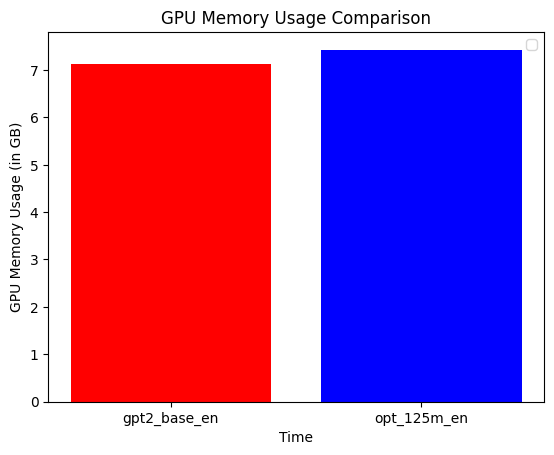

In [48]:
plot_memory_use(gpt2_model_list + opt_model_list,
                gpt2_memory_use | opt_memory_use)

## LoRA GPT2
Source: https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/

In [49]:
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

In [50]:
# This resets "peak" memory usage to "current" memory usage.
tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
lora_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

In [51]:
# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

In [52]:
lora_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

In [53]:
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [54]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer_7 (GPT2Tokenizer)                   │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ gpt2_backbone_7 (GPT2Backbone)                │ (None, None, 768)                      │     124,587,264 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_embedding (ReversibleEmbedding)         │ (None, None, 50257)                    │      38,597,376 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

In [55]:
def get_optimizer_and_loss():
    optimizer = keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.01,
        epsilon=1e-6,
        global_clipnorm=1.0,  # Gradient clipping.
    )
    # Exclude layernorm and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=["bias"])
    optimizer.exclude_from_weight_decay(var_names=["gamma"])
    optimizer.exclude_from_weight_decay(var_names=["beta"])

    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return optimizer, loss

In [56]:
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,
)

optimizer, loss = get_optimizer_and_loss()

lora_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

lora_model.fit(
    train_ds,
    epochs=1,
    callbacks=[gpu_memory_callback],
)
lora_model_memory_usage = gpu_memory_callback.memory_usage

 6/10 [=================>............] - ETA: 3s - loss: 3.8239 - accuracy: 0.2760

10/10 [==============================] - 61s 1s/step - loss: 3.8257 - accuracy: 0.2764


In [57]:
for layer_idx in range(lora_model.backbone.num_layers):
    self_attention_layer = lora_model.backbone.get_layer(
        f"transformer_layer_{layer_idx}"
    )._self_attention_layer

    # Merge query dense layer.
    query_lora_layer = self_attention_layer._query_dense

    A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # Merge value dense layer.
    value_lora_layer = self_attention_layer._value_dense

    A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

In [58]:
generate_text(lora_model, "I like basketball")


Output:
I like basketball. I like to watch it. I love it. I'm not a basketball fan, but I love it. And I love the team. And I'm a big believer in the team and the players.

So I'm not going to lie, I'm excited for the upcoming season. I'm excited for the future. I want to be able to play for the team and play for a team and play for a team. I'm excited to see how the team performs. And I'm excited to see how the team is going to perform this season. I'm excited for the future, I'm excited to see the team perform, I'm excited to watch them play.

So, what is your favorite moment in the NBA?

It's a lot of fun, man. It's a lot of fun. But, I think it's just a matter of time, a matter of time. I'm going to keep trying. I'm going
Total Time Elapsed: 31.33s


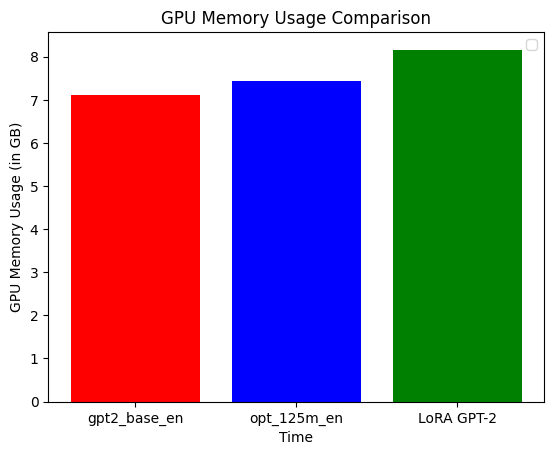

In [59]:
plot_memory_use(gpt2_model_list + opt_model_list + ["LoRA GPT-2"],
                gpt2_memory_use | opt_memory_use | {"LoRA GPT-2": lora_model_memory_usage})